In [3]:
import os
import sys

# Define the relative path to the parent directory
relative_path = '..'

# Append the parent directory to the Python path
parent_directory = os.path.abspath(os.path.join(os.getcwd(), relative_path))
sys.path.append(parent_directory)
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from neuralop.training import BasicLoggerCallback

In [ ]:
#import stuff from library
from functions.fno_wrapper import FNO1dWrapper as FNO1d
from neuralop import Trainer
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from neuralop.datasets.data_transforms import DefaultDataProcessor
from neuralop.datasets.tensor_dataset import TensorDataset
from neuralop.datasets.output_encoder import UnitGaussianNormalizer

In [ ]:
from functions.functions import *

In [ ]:
from functions.seed_utilis import *

seed=2
set_seed(seed) 

In [7]:
# Define parameters
N = 8 # Number of particles
num_states = 5000 # Number of input states
train_ratio = 0.8  # Ratio of training to testing data
batch_size=32
modes= (2**N)//2 #+1
hidden_channels=512
proj_lift_channel= 1024
epochs=100
lr=1e-3

In [8]:
J_min = -2  # min value for J
J_max = 2   # max value for J
Jx = np.random.uniform(J_min, J_max)
Jy = np.random.uniform(J_min, J_max)
Jz = np.random.uniform(J_min, J_max)
h= np.random.uniform(J_min, J_max)
print(Jx,Jy,Jz,h)

-0.25602039143198496 -1.8962950726884347 0.19864991151483657 -0.2587104295268925


In [9]:
import os

# Set the GPU to be used
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [8]:
train_loader,test_loader=create_dataset(N,num_states,train_ratio,batch_size,Jx=Jx,Jy=Jy,Jz=Jz,h=h)

[Dataset] x_train: torch.Size([4000, 2, 256]), y_train: torch.Size([4000, 1, 256])
[Dataset] x_test: torch.Size([1000, 2, 256]), y_test: torch.Size([1000, 1, 256])


In [ ]:
model = FNO1d(n_modes_height=modes,
        hidden_channels=hidden_channels,
        in_channels=2,
        out_channels=1,
        complex=True,
        projection_channels=proj_lift_channel,
        lifting_channels=proj_lift_channel,
        arch_no=1)
model = model.to('cuda')

In [11]:
optimizer = torch.optim.AdamW(model.parameters(),lr=lr) 
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.95) 

In [12]:
#l2loss = LpLoss(d=2, p=2)
#h1loss = H1Loss(d=2)

#train_loss = h1loss
#eval_losses={'h1': h1loss, 'l2': l2loss}

l2loss = LpLoss(d=1, reduce_dims=[0, 1], p=2,reductions=['sum','mean']) 
h1loss = H1Loss(d=1, reduce_dims=[0, 1],reductions=['sum','mean'])

def mse_loss(y_pred, y, **kwargs):
    assert y_pred.shape == y.shape
    assert y_pred.ndim == 3
    diff = (y_pred - y) 
    loss = (diff * diff.conj()).mean(dim=-1).sum(dim=[0])
    return loss.real

train_loss = mse_loss # h1loss
eval_losses={'h1': h1loss, 'l2': l2loss} # adding fidelity 

In [12]:
import wandb
    
config = { 
    "No_of_particles": N,
    "batch_size": batch_size,
    "n_train": num_states * train_ratio,
    "n_test": num_states * (1 - train_ratio),
    "learning_rate": lr,
    "hidden_channel": hidden_channels,
    "proj/lift": proj_lift_channel,
    "epochs": epochs,
}


project="fno_arch_1"
name="fno_random_8"
entity= "fs1132429_" # put your username here


wandb_init_args = dict(
        config=config,
        project=project,
        name=name,
        entity=entity,
    )

In [13]:
device='cuda'


callbacks = [
    BasicLoggerCallback(wandb_init_args)
]
trainer = Trainer(model=model, n_epochs=epochs,
    device=device,
    callbacks=callbacks,
    data_processor=None,
    wandb_log=True,
    log_test_interval=1, # log at every epoch
    use_distributed=False,
    verbose=True)

print(trainer)
trainer.train(train_loader=train_loader,
    test_loaders={"test_loader": test_loader},
    optimizer=optimizer,
    scheduler=scheduler,
    regularizer=False,
    training_loss=train_loss,
    eval_losses=eval_losses,)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: fs1132429 (fs1132429_). Use `wandb login --relogin` to force relogin


using standard method to load data to device.
using standard method to compute loss.
self.override_load_to_device=False
self.overrides_loss=False
Training on 4000 samples
Testing on [1000] samples         on resolutions ['test_loader'].
Raw outputs of size out.shape=torch.Size([32, 1, 256])
[0] time=11.50, avg_loss=0.0028, train_err=0.0910, test_loader_h1=0.7094, test_loader_l2=0.7270
[1] time=10.09, avg_loss=0.0020, train_err=0.0635, test_loader_h1=0.6999, test_loader_l2=0.7133
[2] time=9.96, avg_loss=0.0018, train_err=0.0591, test_loader_h1=0.6744, test_loader_l2=0.6846
[3] time=9.94, avg_loss=0.0013, train_err=0.0413, test_loader_h1=0.4613, test_loader_l2=0.4640
[4] time=9.95, avg_loss=0.0003, train_err=0.0081, test_loader_h1=0.1843, test_loader_l2=0.1987
[5] time=9.97, avg_loss=0.0001, train_err=0.0019, test_loader_h1=0.1353, test_loader_l2=0.1435
[6] time=10.11, avg_loss=0.0000, train_err=0.0011, test_loader_h1=0.1207, test_loader_l2=0.1287
[7] time=10.08, avg_loss=0.0000, train_e

{'test_loader_h1': 0.09034170597791671, 'test_loader_l2': 0.09436291325092315}

In [14]:
torch.save(model.state_dict(), 'models/model_8_simple_case_arch_1_.pth')

In [13]:
model.load_state_dict(torch.load('models/model_8_simple_case_arch_1_.pth')) #load the model architecture first
model.eval()  

FNO1d(
  (fno_blocks): FNOBlocks(
    (convs): SpectralConv(
      (weight): ModuleList(
        (0-3): 4 x ComplexDenseTensor(shape=torch.Size([512, 512, 128]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x ComplexValued(
        (fr): Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False)
        (fi): Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
  )
  (lifting): ComplexValued(
    (fr): MLP(
      (fcs): ModuleList(
        (0): Conv1d(2, 1024, kernel_size=(1,), stride=(1,))
        (1): Conv1d(1024, 512, kernel_size=(1,), stride=(1,))
      )
    )
    (fi): MLP(
      (fcs): ModuleList(
        (0): Conv1d(2, 1024, kernel_size=(1,), stride=(1,))
        (1): Conv1d(1024, 512, kernel_size=(1,), stride=(1,))
      )
    )
  )
  (projection): ComplexValued(
    (fr): MLP(
      (fcs): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
        (1): Conv1d(1024, 1, kernel_size=(1,), stride=(1,))
      )
 

[Dataset] x_train: torch.Size([800, 2, 256]), y_train: torch.Size([800, 1, 256])
[Dataset] x_test: torch.Size([200, 2, 256]), y_test: torch.Size([200, 1, 256])
(200, 256)


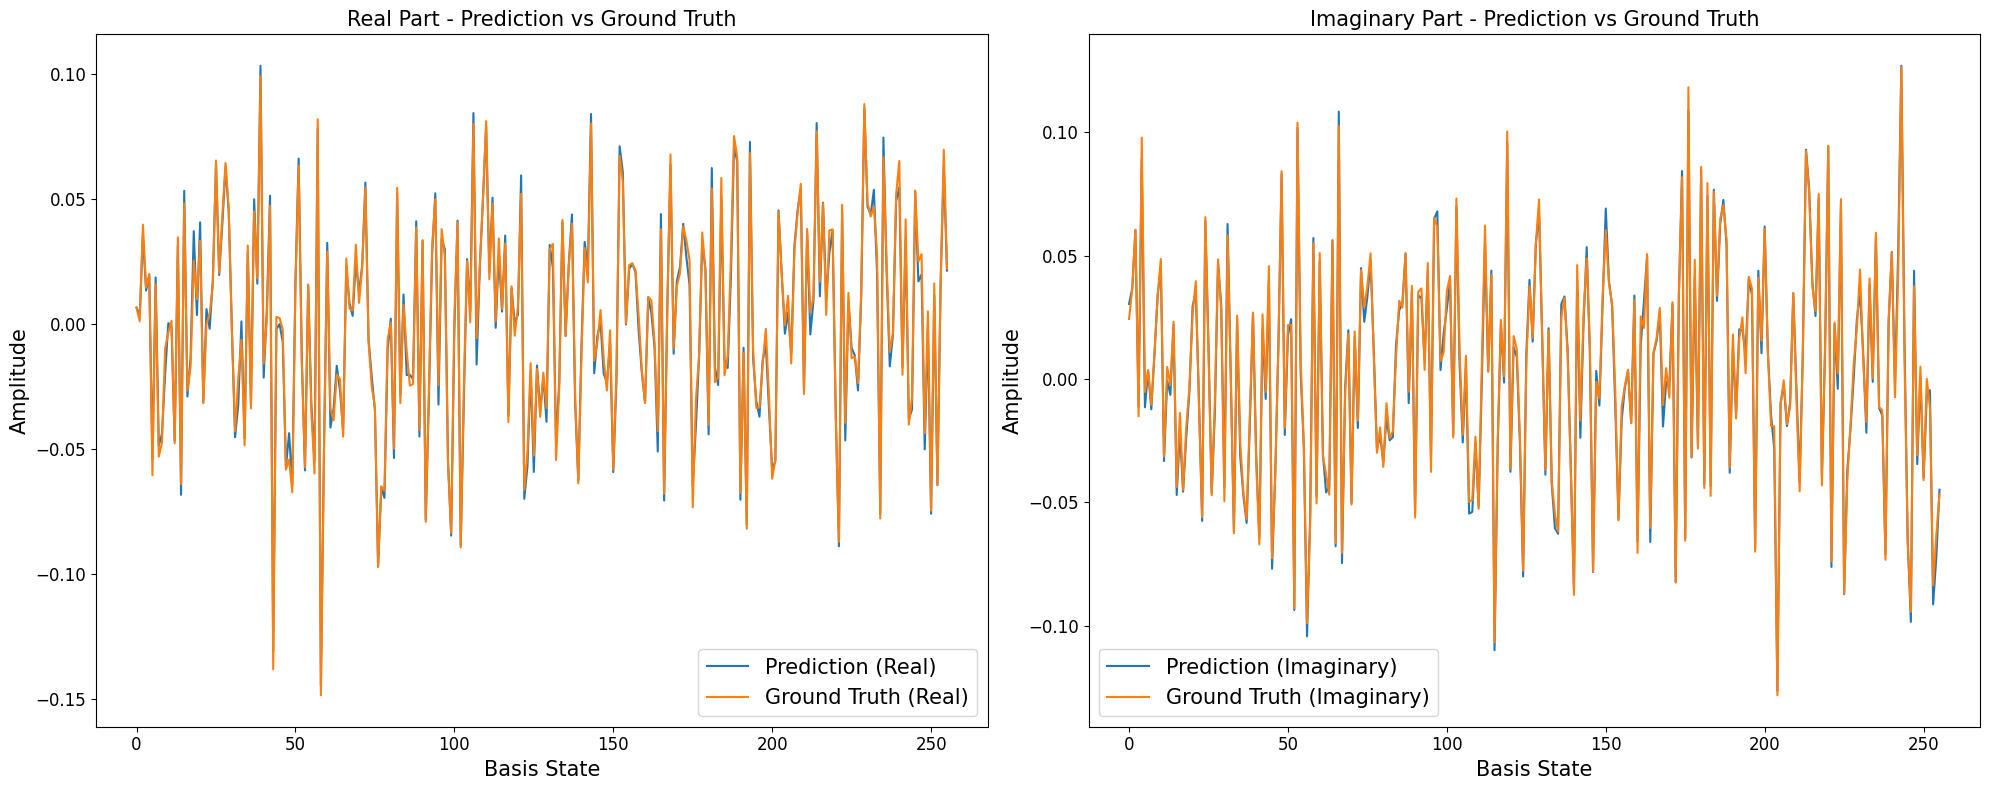

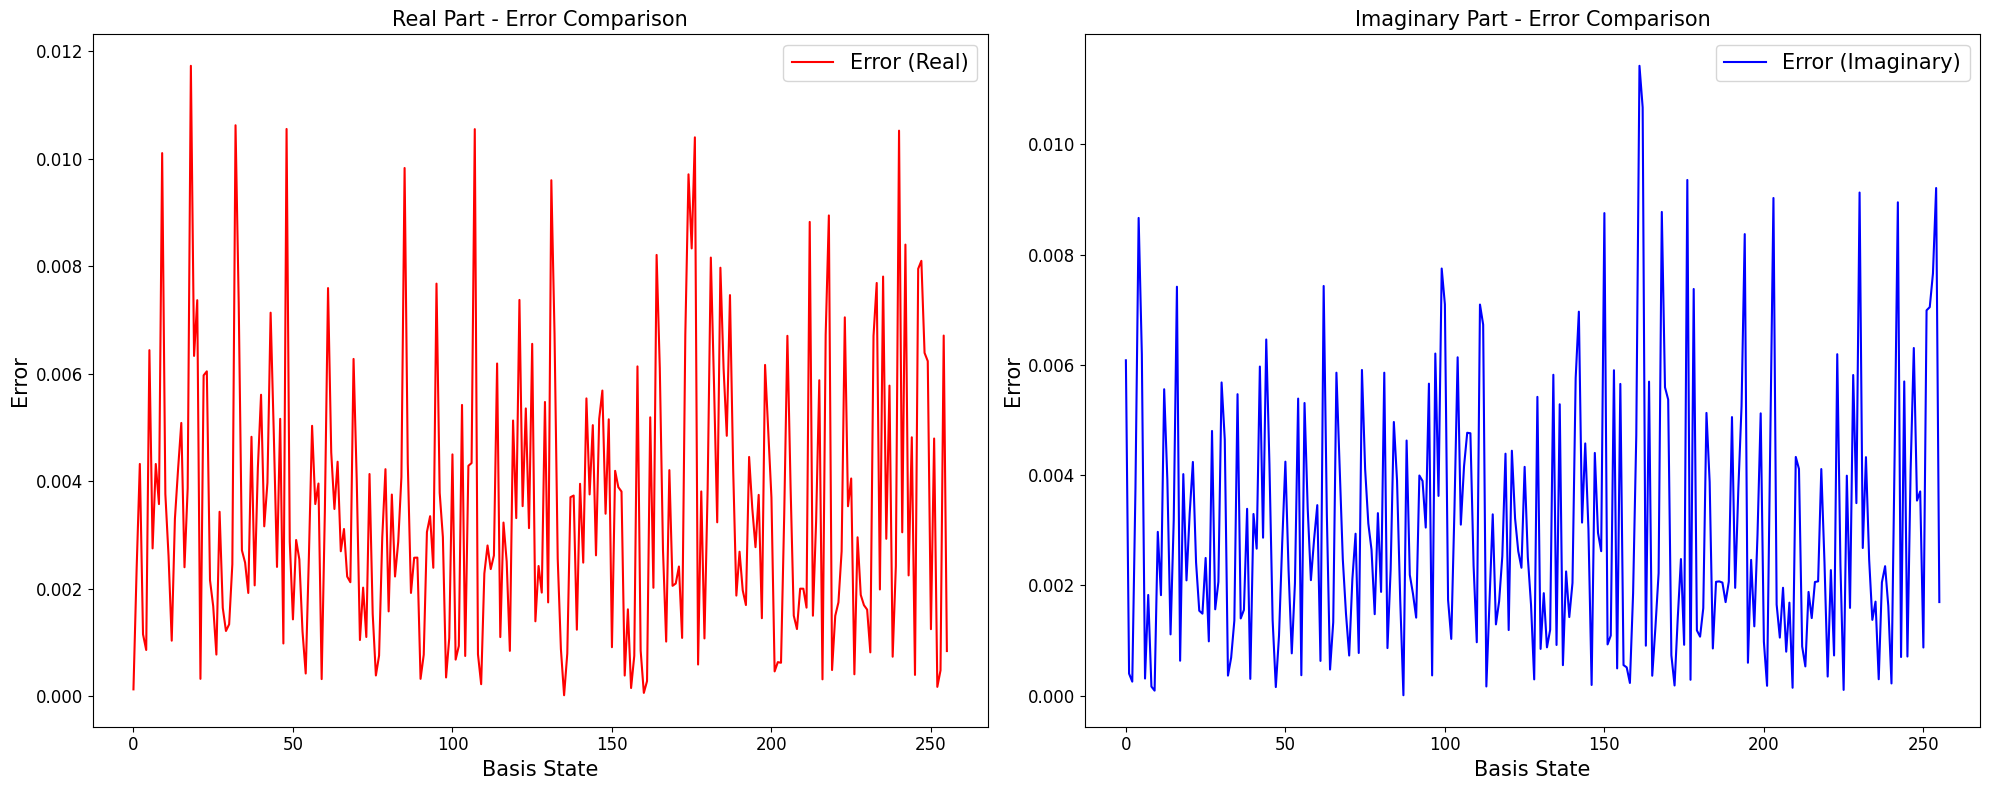

In [15]:

num_states = 1000  # Number of input states
train_ratio = 0.8  # Ratio of training to testing data
batch_size = 5

_, test_loader = create_dataset(N,num_states,train_ratio,batch_size,Jx=Jx,Jy=Jy,Jz=Jz,h=h)
# Assuming `test_loader` is already defined
# Iterate through the test dataset and perform inference
predictions_list = []
ground_truth_list = []
for batch in test_loader:
    x, y = batch['x'].cuda(), batch['y'].cuda()  # Move data to GPU if available
    with torch.no_grad():
        predictions = model(x)  # Perform inference without gradient computation
    predictions_list.append(predictions.squeeze().cpu().numpy())
    ground_truth_list.append(y.squeeze().cpu().numpy())

# Concatenate predictions and ground truth across batches
predictions = np.concatenate(predictions_list)
ground_truth = np.concatenate(ground_truth_list)

print(ground_truth.shape)
# Plot the comparison with error
plot_comparison_with_error(predictions[0], ground_truth[0])  # Plot for the first sample in the dataset


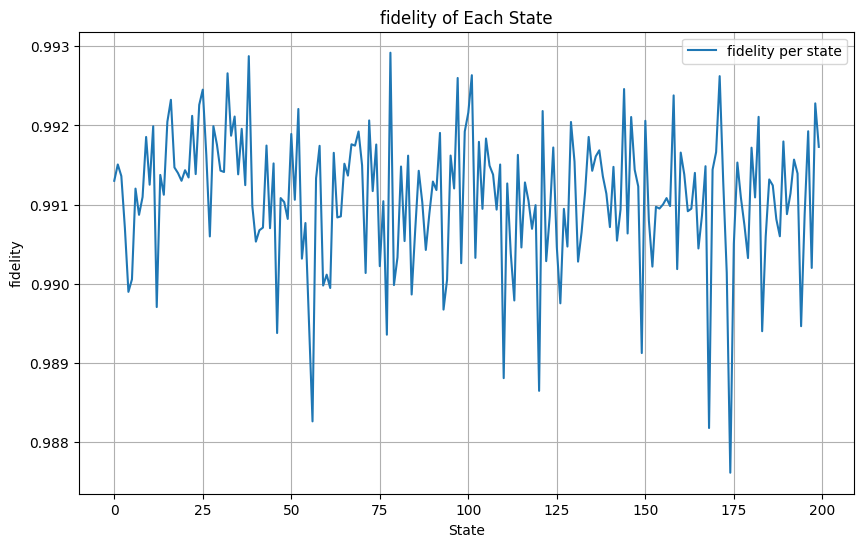

Mean fidelity is 0.9910842444124671


In [16]:



fidelity_vec = []
for i in range(len(predictions)):  # Iterate over the length of predictions
    fid = fidelity_state(predictions[i], ground_truth[i])
    fidelity_vec.append(fid)


# Calculate total MSE
total_fidelity = np.mean(fidelity_vec) 

plt.figure(figsize=(10, 6))
plt.plot(fidelity_vec, label='fidelity per state')
plt.xlabel('State')
plt.ylabel('fidelity')
plt.title('fidelity of Each State')
plt.legend()
plt.grid(True)
plt.show()

print("Mean fidelity is", total_fidelity)


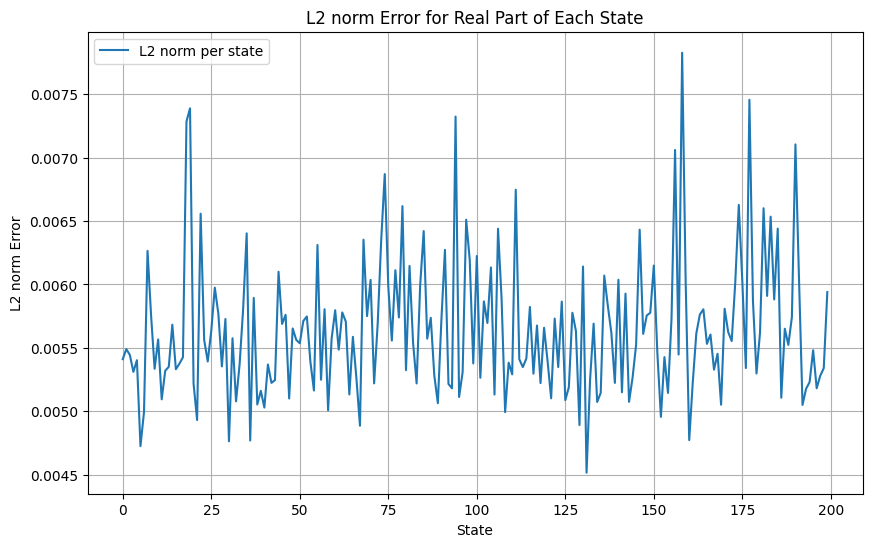

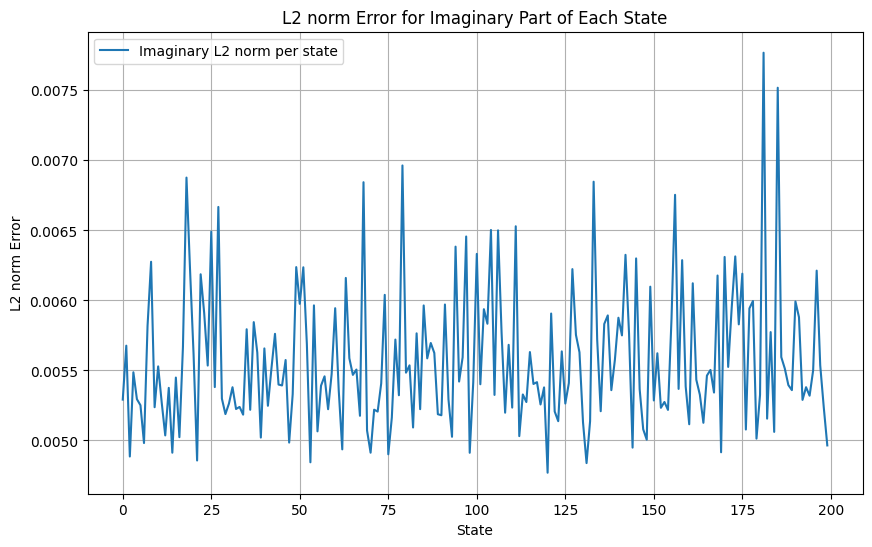

Total Mean Squared Error (Real): 3.213083e-05
Total Mean Squared Error (Imaginary): 3.1356834e-05
L2 norm (Real): 0.0056684064
L2 norm (Imaginary): 0.005599717


In [46]:
# Calculate MSE for each state
state_mse_real = []
state_mse_imag = []
for i in range(len(predictions)):  # Iterate over the length of predictions
    mse_real, mse_imag = calculate_mse(predictions[i], ground_truth[i])
    state_mse_real.append(mse_real)
    state_mse_imag.append(mse_imag)

# Calculate total MSE
total_mse_real = np.mean(state_mse_real) 
total_mse_imag = np.mean(state_mse_imag)

# Plot MSE for each state (real part)
plt.figure(figsize=(10, 6))
plt.plot(np.sqrt(state_mse_real), label='L2 norm per state')
plt.xlabel('State')
plt.ylabel('L2 norm Error')
plt.title('L2 norm Error for Real Part of Each State')
plt.legend()
plt.grid(True)
plt.show()

# Plot MSE for each state (imaginary part)
plt.figure(figsize=(10, 6))
plt.plot(np.sqrt(state_mse_imag), label='Imaginary L2 norm per state')
plt.xlabel('State')
plt.ylabel('L2 norm Error')
plt.title('L2 norm Error for Imaginary Part of Each State')
plt.legend()
plt.grid(True)
plt.show()

print("Total Mean Squared Error (Real):", total_mse_real)
print("Total Mean Squared Error (Imaginary):", total_mse_imag)
print("L2 norm (Real):", np.sqrt(total_mse_real))
print("L2 norm (Imaginary):", np.sqrt(total_mse_imag))

# autoregressive rollout

In [14]:

num_states = 1000  # Number of input states
train_ratio = 0.8  # Ratio of training to testing data
batch_size = 5

rollout_steps = 10  # Number of autoregressive rollout steps
input_states_wavefunction = generate_random_input_states_wavefunction(N, num_states)
print(input_states_wavefunction.shape)
spatial_grid = torch.linspace(0, 1, 2**N).unsqueeze(0).expand(batch_size, -1).cuda()

# Define evolution times
times =  3.14

hamiltonian= construct_hamiltonian(N,Jx,Jy,Jz,h)
index,_= ordered_indices(N,hamiltonian)
# Construct Hamiltonian
hamiltonian2= order_hamiltonian(hamiltonian,index)
_,test_loader=create_dataset(N,num_states,train_ratio,batch_size,Jx=Jx,Jy=Jy,Jz=Jz,h=h)
predictions, ground_truth = autoregressive_rollout(model,test_loader, rollout_steps,spatial_grid,hamiltonian2.cuda(),times)


torch.Size([1000, 256])


[Dataset] x_train: torch.Size([800, 2, 256]), y_train: torch.Size([800, 1, 256])
[Dataset] x_test: torch.Size([200, 2, 256]), y_test: torch.Size([200, 1, 256])


In [15]:
#flattening the tensor from eg: [10,200,16] to [2000,16]
predictions_final = predictions.view(-1, predictions.size(-1))
ground_truth_final=ground_truth.view(-1,ground_truth.size(-1))

# Convert to NumPy array
predictions_numpy = predictions_final.cpu().numpy()
ground_truth_numpy=ground_truth_final.cpu().numpy()
print(predictions_numpy.shape)
print(ground_truth_numpy.shape)

(2000, 256)
(2000, 256)


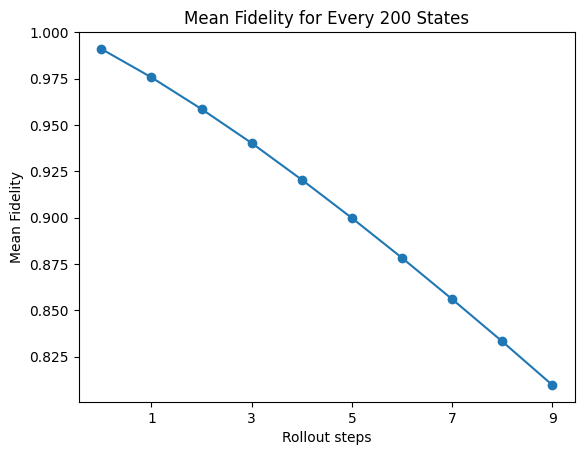

mean fidelity tt: 0.9920028045940512
std fidelity tt: 0.0
Total Mean Fidelity: 0.9062613696193241
total std dev is: 0.05892281126139201


In [16]:
# Calculate fidelities for each pair of states
fidelities = []
test_states=num_states-int(num_states*train_ratio)
range_len= int(rollout_steps*(test_states))
for i in range(range_len):
    fid = fidelity_state(predictions_numpy[i], ground_truth_numpy[i])
    fidelities.append(fid)

# Calculate mean fidelity for every 200 states
mean_fidelities_len = []
std_fidelities_len=[]
for i in range(0, range_len, test_states):
    mean_fidelity = np.mean(fidelities[i:i+test_states])
    std_fidelity =np.std(fidelities[i:i+test_states])
    mean_fidelities_len.append(mean_fidelity)
    std_fidelities_len.append(std_fidelity)

# Calculate total mean fidelity
total_fidelity_tt=np.mean(fidelities[:1])
total_std_tt= np.std(fidelities[:1])
total_mean_fidelity = np.mean(fidelities[1:])
total_std_fidelity = np.std(fidelities[1:])

# Plot mean fidelity for every 200 states
plt.plot(mean_fidelities_len, marker='o')
plt.xlabel('Rollout steps')
plt.ylabel('Mean Fidelity')
plt.xticks([1,3,5,7,9]) #change this for different rollout steps
plt.title(f'Mean Fidelity for Every {test_states} States')
plt.show()

print("mean fidelity tt:", total_fidelity_tt)
print("std fidelity tt:", total_std_tt)
print("Total Mean Fidelity:", total_mean_fidelity)
print("total std dev is:", total_std_fidelity)